## 3D-trajectory introduction

This is jupyter notebook for a gentle introducion to the properties of 3D trajectories.

In [1]:
import partitura
import numpy as np
import itertools
import sys, os
sys.path.insert(0, os.path.dirname(os.getcwd())+ '\\source')

from trajectory import buildTrajectory

ModuleNotFoundError: No module named 'ConvexHullMaxPairOfPoints'

In [2]:
part = partitura.load_musicxml("score_test.musicxml")

note_array = part.note_array
print(note_array.dtype)
notes = [(n[0], n[2]) for n in note_array]


chords = [list(item[1]) for item in itertools.groupby(sorted(notes), key=lambda x: x[0])]
chords = [list(zip(*c))[1] for c in chords]

ignoring direction type: metronome {'parentheses': 'no', 'default-x': '-43.08', 'relative-y': '20.00'}


[('onset', '<f4'), ('duration', '<f4'), ('pitch', '<i4'), ('voice', '<i4'), ('id', '<U256')]


In [3]:
Tonnetz = [3, 4, 5]
trajectory = buildTrajectory(chords, Tonnetz)

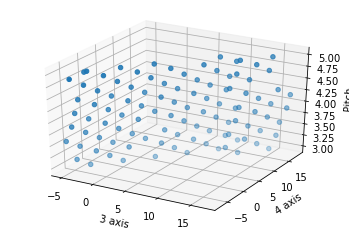

In [4]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
from  trajectory import SetOfPoints

ps, pms = SetOfPoints(trajectory)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs, ys, zs = zip(*ps)

ax.scatter(xs, ys, zs, marker='o')

ax.set_xlabel('3 axis')
ax.set_ylabel('4 axis')
ax.set_zlabel('Pitch')

plt.show()

### Create Edges

In [5]:
def trajectory_edges(trajectory):
    TotalEdges = []
    dist = [-1, 0, 1]
    for dicts in trajectory.chordPositions :
        couples = list(itertools.combinations(dicts.values(), 2))
        for couple in couples:
            (x1, y1, z1), (x2, y2, z2) = couple
            if (x1 - x2) in dist and (y1 - y2) in dist:
                    if not (((x1 - x2) == 1 and (y1 - y2) == -1) or
                            ((x1 - x2) == -1 and (y1 - y2) == 1)):
                        TotalEdges.append(couple)
    return TotalEdges

### Graph from Adjacency Matrix

In [7]:
from  trajectory import weightsOfTrajPoints_Normalized

def trajectory_to_adjacency(trajectory):
    '''Compute the adjacency matrix of the trajectory graph.
    
    Parameters:
    -----------
    trajectory : object
        The harmonic trajectory in 3D of some piece or segment.
    
    Returns:
    --------
    adjacency : array(float)
        The adjacency matrix of the weighted trajectory graph as a normalized array of floats.
    '''
    ps, pms = SetOfPoints(trajectory)
    edges = trajectory_edges(trajectory)
    edges += trajectory.connectingEdges
    weights = weightsOfTrajPoints_Normalized(ps, pms)
    dim = len(ps)
    adjacency = np.zeros((dim, dim))
    for i in range(dim):  
        for j in range(dim):
            if (ps[i], ps[j]) in edges:
                adjacency[i][j] += (weights[ps[i]] + weights[ps[j]])/2
    return adjacency
    


In [8]:
adjacency = trajectory_to_adjacency(trajectory)

print(adjacency)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.01226994 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


<IPython.core.display.Javascript object>


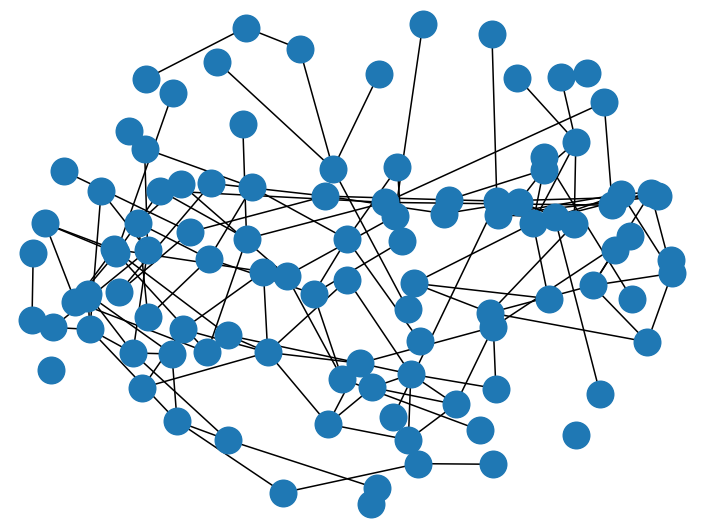

In [9]:
import networkx as nx

graph = nx.from_numpy_array(adjacency, parallel_edges=False, create_using=None)
nx.draw(graph)

### Making the Trajectory Adjacency matrix a Sparce matrix

First calculate the sparsity of the Trajectory Matrix and if it passes a certain threshold yield a sparce matrix.

In [15]:
from scipy.sparse import csr_matrix 

def adjacency_to_sparse(adjacency):
    sparsity = 1.0 - np.count_nonzero(adjacency) / adjacency.size
    print(sparsity)
    if sparsity > 0.7 :
        return csr_matrix(adjacency)
    else :
        print("Adjacency matrix is not sparce enought to compute sparce matrix")

adjacency_to_sparse(adjacency)

0.984375


<104x104 sparse matrix of type '<class 'numpy.float64'>'
	with 169 stored elements in Compressed Sparse Row format>